In [15]:
import numpy as np
from rlberry.manager import (
    AgentManager,
    evaluate_agents,
    plot_writer_data,
    read_writer_data,
)
from rlberry.wrappers import WriterWrapper
from rlberry.agents import AgentWithSimplePolicy
from rlberry.envs import gym_make, Chain
from rlberry_scool import RandomAgent

# Using rlberry

In a reinforcement learning experiment, an **agent** interacts with an **environment**: in a *state* of the environment, the agent chooses an *action* then the state changes depending on that action and the enviroment gives a *reward* to the agent.

A RL agent learns by interacting repeatedly with the environment. Once this learing is performed (the agent is *fitted*), the policy learned by the agent can be evaluated.

When evaluating RL agents, we will want to fit and then evaluate several copies of the same agent, in order to obtain estimates of the mean performance.

The `rlberry` package provides utilities to run several experiments in parallel, average and plot results, optimize hyperparameters, compare to baselines, etc.

### Importing an environment from gymnasium

An environment in `rlberry` is built from a *constructor* and arguments. The constructor `gym_make` is used to create environments from the `gymnasium` library.

In [3]:
env_ctor = gym_make  # environment constructor
env_kwargs = {"id": "CartPole-v1"}  # parameters passed to the environment constructor. Here name of the environment

Calling `env_ctor("CartPole-v1")` would create the gymnasium environment CartPole-v1 (https://gymnasium.farama.org/environments/classic_control/cart_pole/). We will not do that ourselves, but will instead provide the constructor and the arguments to another utility (see below).

### Creating a simple agent

We create a random agent, that chooses actions uniformly at random. The `RandomAgent` class is defined in the `rlberry_scool` package.

In [4]:
random_agent = RandomAgent

### Running an experiment

One of the main feature of rlberry is its `AgentManager` class.

The agent manager spawns agents and environments for training and then once the agents are trained, it uses these agents and new environments to evaluate how well the agents perform. All of these steps can be done several times to assess stochasticity of agents and/or environment.

In [5]:
agent_list = [RandomAgent, RandomAgent]  # list of agents on which we run experiments

fit_budget = 10  # budgent used by an agent in one fit. This is used differently by different agents.
n_fit = 10  # number of parallel fits of the same agent.

agent_managers = [
    AgentManager(  # an AgentManager is used to repeatedly fit and evaluate an agent on an environment
        Agent,
        (env_ctor, env_kwargs),
        fit_budget=fit_budget,
        n_fit=n_fit,
    )
    for Agent in agent_list
]

### Agent training

Calling `fit()` on an agent manager will fit all `n_fit` copies of the agent on the environment.

In [6]:
for manager in agent_managers:
    manager.fit()  # 'fit' will run the agent n_fit times on the environment and store results

[INFO] 14:13: Running AgentManager fit() for RandomAgent with n_fit = 10 and max_workers = None. 
[INFO] 14:13: ... trained! 
[INFO] 14:13: Running AgentManager fit() for RandomAgent with n_fit = 10 and max_workers = None. 
[INFO] 14:13: ... trained! 


### Evaluation and plots

Once the agents are trained, we can evaluate the policies they learned.

[INFO] 14:13: Evaluating RandomAgent... 
[INFO] Evaluation:..........  Evaluation finished 
[INFO] 14:13: Evaluating RandomAgent... 
[INFO] Evaluation:..........  Evaluation finished 


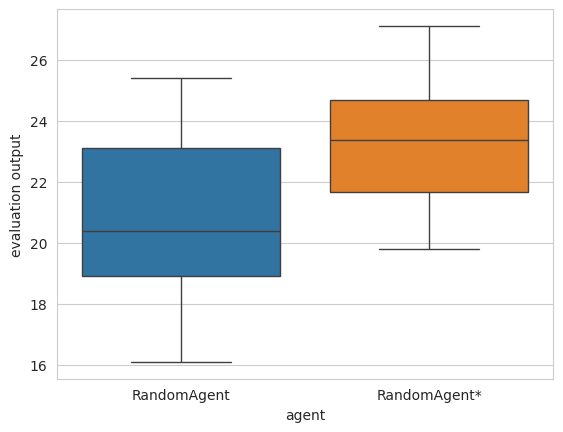

In [7]:
output = evaluate_agents(agent_managers, n_simulations=10, plot=True)

# Comparing the agents during the learning period

In the previous section, we compared the performance of the final policies learned by the agents, after the learning period.

To compare the performance of the agents during the learning period (in the fit method), we can estimate their cumulative reward, which is the sum of the rewards they gather over time.

In [8]:
# New environment on which the rewards are more interesting
env_ctor = Chain
env_kwargs = dict(L=10, fail_prob=0.1)

First, we have to record the reward during the fit as this is not done automatically. To do this, we can use the `WriterWrapper` module.

In [9]:
class RandomAgent2(RandomAgent):
    name = "RandomAgent2"

    def __init__(self, env, **kwargs):
        RandomAgent.__init__(self, env, **kwargs)
        self.env = WriterWrapper(self.env, self.writer, write_scalar="action_and_reward")  # "action", "reward" or "action_and_reward"

Let's make a copy of that class to demonstrate how to compare two agents.

Note that it's important that the new agent has a different name.

In [10]:
class RandomAgent2bis(RandomAgent2):
    name = "RandomAgent2bis"

Then we proceed as previously: we define agent managers and use them to fit the agents

Note that we added an `eval_kwargs` argument to the `AgentManager`: this argument contains instructions on how the agents should be evaluated. In particular, `eval_horizon` puts a limit on the length of the evaluation.

In [11]:
agent_list = [RandomAgent2, RandomAgent2bis]  # list of agents on which we run experiments

fit_budget = 10  # when training an agent, it will use that budget
n_fit = 10  # each agent will be trained n_fits times

agent_managers = [
    AgentManager(  # an AgentManager is used to repeatedly fit and evaluate an agent on an environment
        Agent,
        (env_ctor, env_kwargs),
        fit_budget=fit_budget,
        n_fit=n_fit,
        eval_kwargs=dict(eval_horizon=20, n_simulations=10),
    )
    for Agent in agent_list
]

In [12]:
for manager in agent_managers:
    manager.fit() 

[INFO] 14:13: Running AgentManager fit() for RandomAgent2 with n_fit = 10 and max_workers = None. 
[INFO] 14:13: ... trained! 
/home/degenne/miniconda3/envs/rlberryscool/lib/python3.9/site-packages/rlberry/utils/writers.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(self._data[tag])], ignore_index=True)
/home/degenne/miniconda3/envs/rlberryscool/lib/python3.9/site-packages/rlberry/utils/writers.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.

We can plot the data we logged previously.

`plot_writer_data` shows, for each agent, the mean of the data plotted (here the rewards) and a confidence interval (90% percentile).

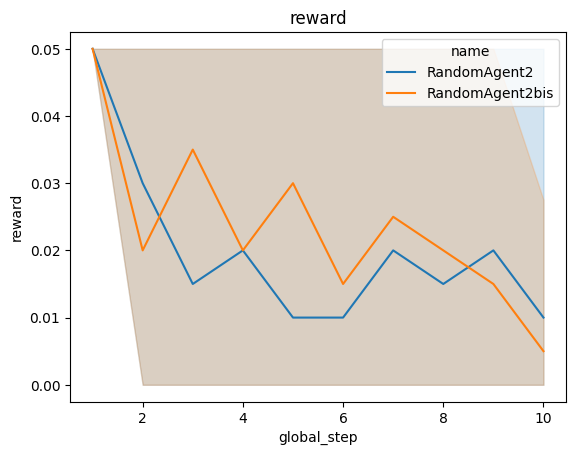

In [13]:
df = plot_writer_data(agent_managers, tag="reward")

It is also possible to preprocess the data before plotting it.

Here we plot the cumulative reward.

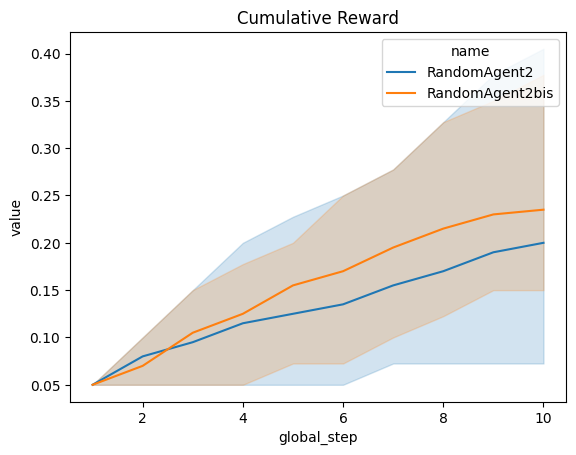

In [14]:
def cumulative_reward(rewards):
    return np.cumsum(rewards)


# Plot of the cumulative reward.
output = plot_writer_data(
    agent_managers,
    tag="reward",
    preprocess_func=cumulative_reward,
    title="Cumulative Reward",
)